# House Prices: Advanced Regression Techniques (Kaggle)

## 02-linear with data scaling

Sources:
* Kaggle competition: https://www.kaggle.com/c/house-prices-advanced-regression-techniques
* Check missing values: https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction by Will Koehrsen
* Neural net implementation: https://yashuseth.blog/2018/07/22/pytorch-neural-network-for-tabular-data-with-categorical-embeddings/ by Yashu Seth

## Problem description

**Previous**:
We try to predict house prices based on a number of continuous and categorical variables.
In the first step, the prediction will be made using only a small selection of continuous variables:

* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* TotalBsmtSF: Total square feet of basement area
* SalePrice: target variable

We will use a very simple network: a linear network with a single non-linearity.

**Now**:
In order to make it a little easier for gradient descent to converge to a minimum, we will scale the input data to have 0 mean and a standard deviation of 1. For a discussion on why it is useful to scale input data, see https://stats.stackexchange.com/questions/249378/is-scaling-data-0-1-necessary-when-batch-normalization-is-used. We will not scale the target data, following this discussion: https://stats.stackexchange.com/questions/111467/is-it-necessary-to-scale-the-target-value-in-addition-to-scaling-features-for-re.

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Show more rows and columns in the pandas output
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Helpers

In [4]:
def show_missing(df, show_all=True):
    """    
    Shows absolute and relative number of missing values for each column of a dataframe,
    show_all=True also shows columns with no missing values.
    """
    mis_val_abs = df.isnull().sum()
    mis_val_rel = df.isnull().sum()/df.shape[0]
    mis_val_table = pd.concat([df.dtypes, mis_val_abs, mis_val_rel], axis=1)
    mis_val_table = mis_val_table.rename(columns={0: 'dtype', 1: 'Missing abs', 2: 'Missing rel'})

    if show_all:
        # Sort table descending by relative amount missing
        mis_val_table = mis_val_table.sort_values('Missing rel', ascending=False).round(3)
    else:
        # Sort table descending by relative amount missing, remove columns where no values are missing
        mis_val_table = mis_val_table[mis_val_table.iloc[:, 1] != 0].sort_values('Missing rel', ascending=False).round(3)
    
    return mis_val_table

## Load data

In [5]:
PATH = Path('../data/houseprice/')
#!dir {PATH}  # For Windows
!ls {PATH}

data_description.txt  sample_submission.csv  train.csv
models		      test.csv		     train_tiny.csv


In [6]:
# Import data
df_train = pd.read_csv(PATH/'train.csv', sep=',', header=0,
                       usecols=['LotFrontage', 'LotArea', '1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'SalePrice'])
df_train.shape

(1460, 6)

In [7]:
df_train.columns

Index(['LotFrontage', 'LotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'SalePrice'],
      dtype='object')

## Pre-processing

First, we take a look at a couple of rows and some descriptive statistics. This gives us an idea about the scale of values, and helps to decide if some continuous variables should perhaps be treated as categorical. In this case all variables will be treated as continuous.

We also check for missing values. If we find any, we have two options: remove the rows that contain missing values (which might lead to losing a lot of observations), or replace them with other values so that the network can use them. Common values used as a replacement are the mean or the median of the series, or some constant.

In [8]:
df_train.head()

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,SalePrice
0,65.0,8450,856,856,854,208500
1,80.0,9600,1262,1262,0,181500
2,68.0,11250,920,920,866,223500
3,60.0,9550,756,961,756,140000
4,84.0,14260,1145,1145,1053,250000


In [9]:
df_train.describe()

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,SalePrice
count,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,70.049958,10516.828082,1057.429452,1162.626712,346.992466,180921.195890
std,24.284752,9981.264932,438.705324,386.587738,436.528436,79442.502883
min,21.000000,1300.000000,0.000000,334.000000,0.000000,34900.000000
25%,59.000000,7553.500000,795.750000,882.000000,0.000000,129975.000000
50%,69.000000,9478.500000,991.500000,1087.000000,0.000000,163000.000000
75%,80.000000,11601.500000,1298.250000,1391.250000,728.000000,214000.000000
max,313.000000,215245.000000,6110.000000,4692.000000,2065.000000,755000.000000


In [10]:
show_missing(df_train)

,dtype,Missing abs,Missing rel
LotFrontage,float64,259,0.177
LotArea,int64,0,0.000
TotalBsmtSF,int64,0,0.000
1stFlrSF,int64,0,0.000
2ndFlrSF,int64,0,0.000
SalePrice,int64,0,0.000


Since there are missing values in *LotFrontage*, we need to replace those values with something that the model can handle. The median and the mean of *LotFrontage* are roughly the same, so we will replace the missing values with the median of the series.

In [11]:
df_train.LotFrontage.median(), df_train.LotFrontage.mean()

(69.0, 70.04995836802665)

In [12]:
df_train.LotFrontage = df_train.LotFrontage.fillna(df_train.LotFrontage.median())

In [13]:
show_missing(df_train)

,dtype,Missing abs,Missing rel
LotFrontage,float64,0,0.0
LotArea,int64,0,0.0
TotalBsmtSF,int64,0,0.0
1stFlrSF,int64,0,0.0
2ndFlrSF,int64,0,0.0
SalePrice,int64,0,0.0


In [14]:
# Seperate the target variable from the df
df_y = df_train.SalePrice
df_train.drop('SalePrice', axis=1, inplace=True)

### New

We will use the *StandardScaler* from the *sklearn* library to scale our data. Although we could easily do the scaling manually, it is convenient to use a scaler so we can later apply the exact same scaling onto different data as well, e.g. **validation data** or **test data**.

In [15]:
from sklearn import preprocessing

In [16]:
std_scaler = preprocessing.StandardScaler()
std_scaler.fit(df_train)

/home/michael/anaconda3/envs/p36-fastai10-cuda100/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [17]:
df_train = pd.DataFrame(std_scaler.transform(df_train), columns=df_train.columns)

/home/michael/anaconda3/envs/p36-fastai10-cuda100/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [18]:
df_train.describe()

,LotFrontage,LotArea,TotalBsmtSF,1stFlrSF,2ndFlrSF
count,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03,1.460000e+03
mean,2.801602e-16,-4.202783e-17,2.063038e-16,7.686013e-17,-3.269835e-17
std,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00,1.000343e+00
min,-2.219047e+00,-9.237292e-01,-2.411167e+00,-2.144172e+00,-7.951632e-01
25%,-4.479400e-01,-2.969908e-01,-5.966855e-01,-7.261556e-01,-7.951632e-01
50%,-3.922314e-02,-1.040633e-01,-1.503334e-01,-1.956933e-01,-7.951632e-01
75%,4.149067e-01,1.087080e-01,5.491227e-01,5.915905e-01,8.731117e-01
max,1.104155e+01,2.051827e+01,1.152095e+01,9.132681e+00,3.936963e+00


# PyTorch

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [20]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

## Dataset, dataloader

In [21]:
# Convert all data containers to tensors
t_train = torch.tensor(df_train.values, dtype=torch.float32, device=device)
t_y = torch.tensor(df_y.values, dtype=torch.float32, device=device)
#t_y = (t_y-t_y.mean())/t_y.std()

In [22]:
# Dataset
train_ds = TensorDataset(t_train, t_y)

In [23]:
# Dataloader
batch_size=64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

## Model

In [24]:
class LinearNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Layers
        self.linear1 = nn.Linear(5, 100)
        self.act1 = nn.ReLU()
        self.linear2 = nn.Linear(100, 1)        
    
    def forward(self, x):        
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x)
        
        return x

In [25]:
# Instantiate the model
model = LinearNet().to(device)

## Optimizer

In [26]:
lr = 0.1
opt = torch.optim.Adam(model.parameters(), lr=lr)

## Loss

In [27]:
loss_fn = F.mse_loss

## Train

In [28]:
losses = []
def fit(num_epochs, model, loss_fn, opt):    
    for epoch in range(num_epochs):
        for xb, yb in train_dl:
            # Forward            
            preds = model(xb)
            loss = loss_fn(preds, yb)
            losses.append(loss)
            
            # Gradient descent
            loss.backward()
            opt.step()
            opt.zero_grad()
            
        if epoch%20==0:
            print('Training loss:', loss_fn(model(t_train), t_y))

In [29]:
# Train for 300 epochs
fit(num_epochs=300, model=model, loss_fn=loss_fn, opt=opt)

Training loss: tensor(3.8739e+10, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(7.0684e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.4403e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3364e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3178e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3130e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3111e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3088e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3081e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3076e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3087e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3093e+09, device='cuda:0', grad_fn=<MseLossBackward>)
Training loss: tensor(6.3081e+09, device='cuda:0', grad_fn=<MseL

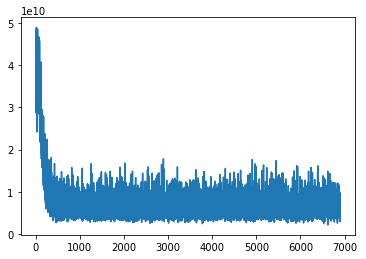

In [30]:
plt.plot(losses)

In [31]:
preds = model(t_train)

In [32]:
torch.cat([preds, t_y.reshape(-1,1)], dim=1)[:10, :]

tensor([[180627.2500, 208500.0000],
        [179909.3594, 181500.0000],
        [180783.3281, 223500.0000],
        [180297.3281, 140000.0000],
        [181802.2031, 250000.0000],
        [179423.2031, 143000.0000],
        [181449.5781, 307000.0000],
        [181732.9844, 200000.0000],
        [180990.3438, 129900.0000],
        [179363.1406, 118000.0000]], device='cuda:0', grad_fn=<SliceBackward>)

As explained before, the model is still suffering from a lack of data. The linear model has a hard time to explain the non-linear price behaviour.

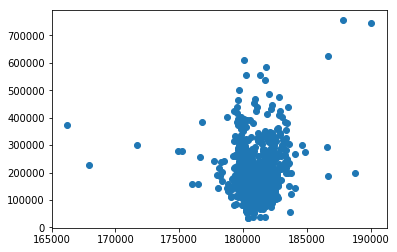

In [173]:
plt.scatter(preds.detach().cpu().numpy(), t_y.reshape(-1,1).detach().cpu())